In [1]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib seaborn
    import matplotlib.pyplot as plt
    
import numpy as np
import logging 

from neurolib.models.aln import ALNModel
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim

import pandas as pd
import matplotlib.pyplot as plt
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim

# Prepare data

In [3]:
def read_triggers(trigger_file):
    """Reads triggers from a file and returns a DataFrame."""
    with open(trigger_file, 'r') as file:
        lines = file.readlines()
    
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            label, type_, time = parts
            data.append([label, type_, float(time)])
    
    return pd.DataFrame(data, columns=['Label', 'Type', 'Time'])

def extract_fixation_periods(triggers):
    """Extracts periods of the next 10 timestamps after each fixation and their labels."""
    fixation_indices = triggers[triggers['Label'] == '+'].index
    all_sets = []
    
    for index in fixation_indices:
        # Start from the next row after fixation and take the next 10 timestamps
        period = triggers.iloc[index + 1:index + 11]
        if not period.empty:
            initial_time = period['Time'].iloc[0]
            # Calculate relative times and labels for each event in the period
            relative_times = period['Time'].apply(lambda x: x - initial_time).tolist()
            labels = [1 if typ == 'target' else 0 for typ in period['Type']]
            all_sets.append([np.array(relative_times), np.array(labels)])
    
    return all_sets

trigger_files = [#'/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/triggers.txt', 
                   '/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/triggers_2.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/triggers.txt',
                   '/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/triggers.txt',
#                  '/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/triggers.txt'
                 
                 ]

# Initialize sets_of_data outside the loop to accumulate data from all files
sets_of_data = []

for trigger_file in trigger_files:
    triggers = read_triggers(trigger_file)
    sets_of_data.extend(extract_fixation_periods(triggers))  # Extend to accumulate across files

In [40]:
def read_triggers(trigger_file):
    """Reads triggers from a file and returns a DataFrame."""
    with open(trigger_file, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            label, type_, time = parts
            data.append([label, type_, float(time)])

    return pd.DataFrame(data, columns=['Label', 'Type', 'Time'])

def extract_fixation_periods(triggers):
    """Extracts periods of the next 10 timestamps after each fixation."""
    fixation_indices = triggers[triggers['Label'] == '+'].index
    periods = []
    
    for index in fixation_indices:
        # Check if there are at least 10 entries after the fixation index
        end_index = index + 11
        if end_index > len(triggers):
            end_index = len(triggers)
        period = triggers.iloc[index + 1:end_index]
        if not period.empty:
            periods.append(period['Time'].tolist())
    
    return periods

import pandas as pd

def extract_data_from_intervals(raw_data_file, periods):
    """Extracts data rows corresponding to each period of timestamps and interpolates outliers."""
    raw_data_1 = pd.read_csv(raw_data_file, skiprows=2)
    raw_data = raw_data_1[20000:len(raw_data_1)-1]
    # Calculate 5th and 95th percentiles to determine outliers
    low_quantiles = raw_data.quantile(0.05)
    high_quantiles = raw_data.quantile(0.95)

    # Mask values that are outliers
    is_outlier = (raw_data < low_quantiles) | (raw_data > high_quantiles)
    filtered_data = raw_data.where(~is_outlier, other=pd.NA)

    # Interpolate missing values that were marked as outliers
    interpolated_data = filtered_data.interpolate(method='linear', limit_direction='both')
    print(len(interpolated_data))
    results = []
    relative_time=[]
    period_raw_data = []
    for period in periods:
        if period:
            # Get the start and end timestamps of the period
            start_time = period[0]
            end_time = period[-1]
            
            # Filter the data based on timestamps
            period_data = interpolated_data[(interpolated_data['lsl_timestamp'] >= start_time) & (interpolated_data['lsl_timestamp'] <= end_time)]
            period_data['relative_time'] = period_data['lsl_timestamp'] - start_time
            # Calculate the average of certain columns, excluding some
            cols_to_avg = period_data.columns.difference(['lsl_timestamp', 'timestamp', 'relative_time', 'TRG', "X1","X2", "X3","A2","T3","T4","Fp1","Fp2","F7","F8","P3","P4","F3","F4","C3","C4"])
            period_data['average'] = period_data[cols_to_avg].mean(axis=1)
            period_raw_data.append(raw_data_1[(raw_data_1['lsl_timestamp'] >= start_time) & (raw_data_1['lsl_timestamp'] <= end_time)])
            relative_time.append(period_data['relative_time'])
            results.append(period_data[cols_to_avg])
    print(cols_to_avg)
    
    return results, interpolated_data, relative_time, period_raw_data, raw_data_1

# File pairs
file_pairs = [
     #('/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/triggers.txt', '/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/raw_data.csv'),
     ('/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/triggers_2.txt', '/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/raw_data_2.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/raw_data.csv'),
     ('/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/triggers.txt', '/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/raw_data.csv')
]

filtered_raw_data=[]
filtered_data_sets = []
for trigger_file, raw_data_file in file_pairs:
    triggers = read_triggers(trigger_file)
    fixation_periods = extract_fixation_periods(triggers)
    results, filtered_data, relative_time, period_raw_data, raw_data=extract_data_from_intervals(raw_data_file, fixation_periods)
    filtered_data_sets.extend(results)
    filtered_raw_data.append(filtered_data)


295456
Index(['Cz', 'Fz', 'O1', 'O2', 'Pz', 'T5', 'T6'], dtype='object')


/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_13968/3411436059.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['relative_time'] = period_data['lsl_timestamp'] - start_time
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_13968/3411436059.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['average'] = period_data[cols_to_avg].mean(axis=1)
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_13968/3411436059.py:59: SettingWithCopyWarning: 
A value is

251033
Index(['Cz', 'Fz', 'O1', 'O2', 'Pz', 'T5', 'T6'], dtype='object')


/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_13968/3411436059.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['relative_time'] = period_data['lsl_timestamp'] - start_time
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_13968/3411436059.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['average'] = period_data[cols_to_avg].mean(axis=1)
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_13968/3411436059.py:59: SettingWithCopyWarning: 
A value is

In [44]:
start_time = raw_data.iloc[0]['lsl_timestamp']
raw_data['relative_time'] = raw_data['lsl_timestamp'] - start_time

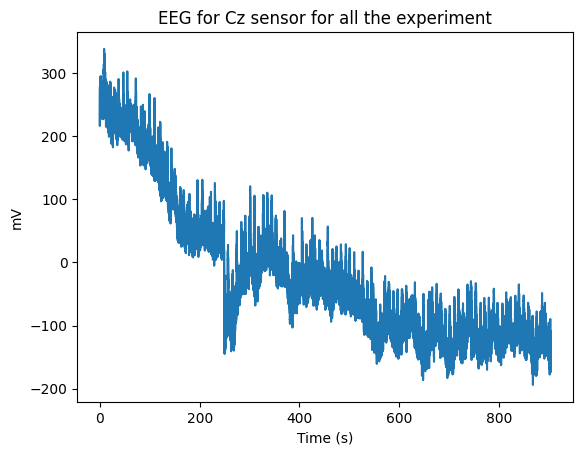

In [45]:
plt.plot(raw_data['relative_time'],raw_data['Cz'])
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title('EEG for Cz sensor for all the experiment')
plt.show()

In [14]:
print(relative_time[10])

36072    0.009324
36073    0.009326
36074    0.009327
36075    0.009329
36076    0.009331
           ...   
36886    2.708779
36887    2.708781
36888    2.708783
36889    2.708785
36890    2.708787
Name: relative_time, Length: 819, dtype: float64


In [50]:
def membrane_potential_thersholded(rates_exc, rates_inh, synaptic_efficiency, kernel_size, threshold):
    #combined_signal = rates
    
    #combined_signal = np.ravel(rates * 0.05)
    combined_signal = (rates_exc-rates_inh)*synaptic_efficiency

    # Create a square kernel for convolution
    square_kernel = np.ones(kernel_size) / kernel_size # Normalize the kernel to maintain amplitude scale

    # Convolve the combined signal with the square kernel
    convolved_signal = np.convolve(combined_signal, square_kernel, mode='same')

    # Apply a threshold to the convolved signal
    thresholded_signal = np.where(convolved_signal < threshold, convolved_signal, 0.1)
    return convolved_signal

In [85]:
import numpy as np

def square_signal_generator(dataset):
    time_array_2 = dataset[0]
    value_array_2 = dataset[1]
    new_size = 810  # Convert to integer
    new_time_array_2 = np.linspace(time_array_2[0], time_array_2[-1], new_size)

    # Expand the value array to match the new time array, propagating labels
    new_value_array_2 = np.zeros_like(new_time_array_2)

    # Propagate values by setting the range of 1's between known points
    for i, value in enumerate(value_array_2):
        if value == 1:
            if i < len(value_array_2) - 1:
                next_change_index = np.where(value_array_2[i+1:] != value)[0]
                if len(next_change_index) > 0:
                    end_time = time_array_2[i + 1 + next_change_index[0]]
                else:
                    end_time = new_time_array_2[-1]
                start_index = np.searchsorted(new_time_array_2, time_array_2[i])
                end_index = np.searchsorted(new_time_array_2, end_time)
                new_value_array_2[start_index:end_index] = 1
            else:
                end_time = new_time_array_2[-1]
                end_index = np.searchsorted(new_time_array_2, end_time)
                new_value_array_2[end_index] = 1

    duration = 81
    dt = 0.1
    square_signal = new_value_array_2
    indices = np.where(square_signal == 1)[0]
    if len(indices)==0:
        inp = stim.ZeroInput(n=2).as_array(duration, dt)
    else:
        first_one = int(indices[0]/10)
        last_one = int(indices[-1]/10)
        inp = stim.StepInput(step_size=1, start=first_one, end=last_one, n=2).as_array(duration, dt)
    return inp, new_time_array_2, new_value_array_2

# Data for multiple outputs

In [91]:
model = ALNModel()
model.params['duration'] = 400
model.params["sigma_ou"] = 0.1
values_Cz=[]
values_Fz=[]
values_O1=[]
values_O2=[]
values_Pz = []
values_T5 = []
valyes_T6 = []
square_signals=[]
rates=[]
rates_exc=[]
rates_inh=[]
synaptic_efficiency = 0.05  # Conversion from firing rate to synaptic current
kernel_size = 50  # Size of the square wave, represents the integration window in time steps
threshold = 0.5   # Threshold to highlight significant activity
times = []
model_output=[]
total_rates = []
square_signals_2=[]
for i in range(0, len(filtered_data_sets)-1):
    if(len(filtered_data_sets[i]['O1'][0:810])==810):
        values_Cz.append(np.array(filtered_data_sets[i]['Cz'][0:810]))
        values_Fz.append(np.array(filtered_data_sets[i]['Fz'][0:810]))
        values_O1.append(np.array(filtered_data_sets[i]['O1'][0:810]))
        #max_value = np.max(filtered_data_sets[i]['average'][0:810])
    #square_signal, time =square_signal_generator(sets_of_data[i], max_value)[0]
    square_signal, time, sq =square_signal_generator(sets_of_data[i])
    square_signals_2.append(sq)
    times.append(time)
    square_signals.append(square_signal)
    model.params["ext_exc_current"] = square_signal
    model.run()
    #rates.append(membrane_potential_thersholded(model.output.T, synaptic_efficiency, kernel_size, threshold))
    rates.append(membrane_potential_thersholded(model['rates_exc'][0],model['rates_inh'][0], synaptic_efficiency, kernel_size, threshold))
    rates_exc.append(model['rates_exc'][0])
    rates_inh.append(model['rates_inh'][0])
    exc_inh = (model['rates_exc'][0]-model['rates_inh'][0])*0.05
    total_rates.append(exc_inh)
    model_output.append(model.output.T)

In [116]:
len(square_signals[0][1])

810

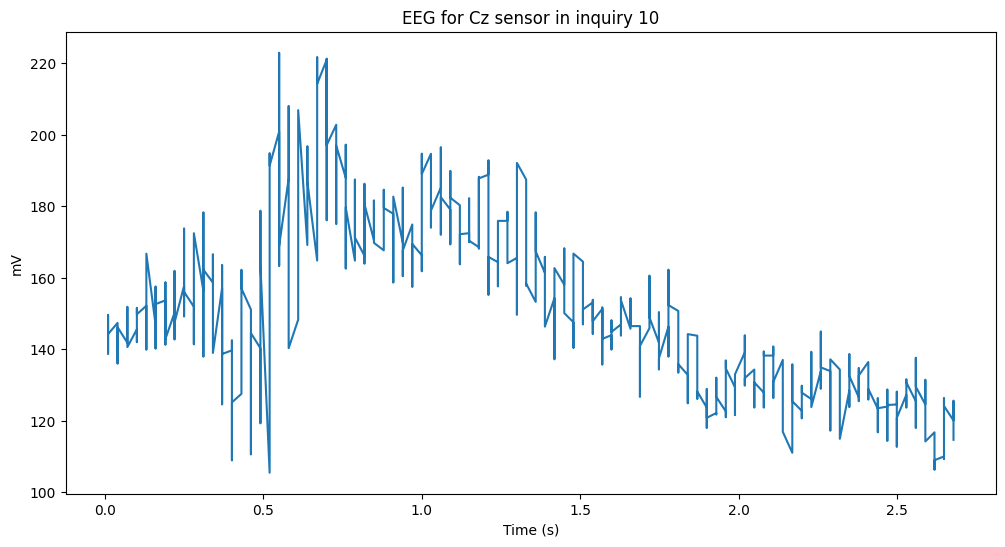

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(relative_time[10][0:810], period_raw_data[10]['Cz'][0:810])
#plt.plot(relative_time[10][0:810], square_signals[0][0]*200)
plt.xlabel('Time (s)')
plt.ylabel('mV')
plt.title('EEG for Cz sensor in inquiry 10')
plt.show()

In [8]:
import numpy as np
from scipy.signal import butter, sosfilt, sosfreqz

# Define the filter parameters
fs = 1000  # Sampling frequency
lowcut = 0.1  # Low cutoff frequency
highcut = 40  # High cutoff frequency
order = 5  # Filter order

# Define the function to apply the bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')
    y = sosfilt(sos, data)
    return y

# Apply the bandpass filter to values_O1
values_O1_filtered = []
for value in values_O1:
    filtered_value = butter_bandpass_filter(value, lowcut, highcut, fs, order=order)
    values_O1_filtered.append(filtered_value)

# Convert the filtered values back to a numpy array
values_O1_filtered = np.array(values_O1_filtered)


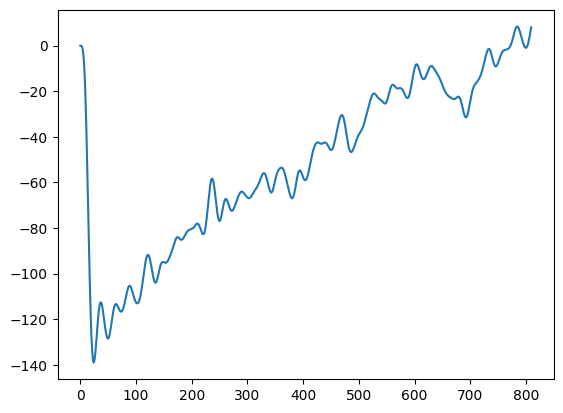

In [15]:
plt.plot(values_O1_filtered[100])
plt.show()

# Model

In [41]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

rates_syn=np.array((np.array(rates_exc)-np.array(rates_inh)))*0.05
X = np.array(total_rates[0:100])
y = np.array(data_np)/1000 #data in mV

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
linear_model = LinearRegression()

# Fit model on training data
linear_model.fit(X_train, y_train)

# Predict on testing data
y_pred = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.020952301329418797


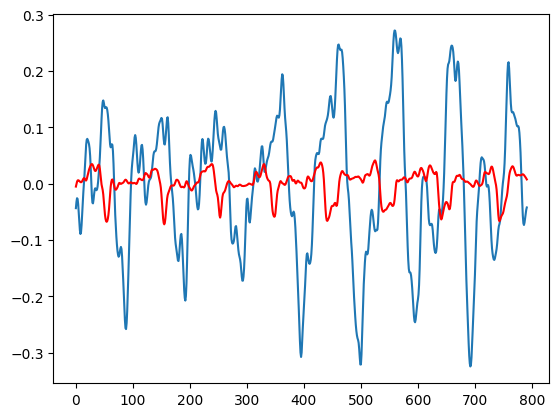

In [43]:
prediction = linear_model.predict([X_test[0]])
plt.plot(prediction[0])
plt.plot(y_test[0], c='r')
plt.show()

# DeapUtils functions

In [17]:
# This file contains helper functions for DEAP
# including additional mutation, crossover and selection operators.

import random
import copy
import numpy as np


# def indivAsDict_adapt(individual, ParametersInterval, paramInterval):
#     """
#     Convert an individual to a dictionary
#     """
#     return ParametersInterval(*(individual[: len(paramInterval)]))._asdict().copy()


def randomParameters(paramInterval):
    """
    Generate a sequence of random parameters from a ParamsInterval using a uniform distribution.
    Format: [mean_par1, mean_par2, ...]
    """
    params = [np.random.uniform(*pI) for pI in paramInterval]
    return params

def randomParametersAdaptive(paramInterval):
    """
    Generate a sequence of random parameters from a ParamsInterval using a uniform distribution.
    Format: [mean_par1, mean_par2, ..., sigma_par1, sigma_par2, ...]
    The second half of the parameter list is set of adaptive mutation std deviation parameters.
    """
    params = []
    for key, interval in paramInterval.items():
        params.append(np.random.uniform(interval[0], interval[1]))
    # The initial adaptation parameters are chosen according to the initial parameter range:
    defaultAdaptation = [abs(interval[1] - interval[0]) / 3 for interval in paramInterval.values()]
    # add sigma's to the list of means
    params.extend(defaultAdaptation)
    return params


def mutateUntilValid(pop, paramInterval, MUTATE_P={}, maxTries=100):
    """Checks the validity of new individuals' parameter. If they are invalid 
    (for example if they are out of the predefined parameter space bounds), 
    mutate the individual, until valid.

    :param pop: population to mutate
    :param paramInterval: parameter interval dictionary
    :param MUTATE_P: mutation parameters (e.g., {'sigma_scale': 2.0})
    :param maxTries: how many mutations to try until valid
    """
    intervals=[]
    for key, interval in paramInterval.items():
        intervals.append(interval)
    for i, ind in enumerate(pop):
        ind_bak = copy.copy(ind)
        ind = mutateIndividual(ind, paramInterval, MUTATE_P)
        nMutations = 0
        while not checkParamValidity(ind, paramInterval) and nMutations < maxTries:
            ind = copy.copy(ind_bak)
            ind = mutateIndividual(ind, paramInterval, MUTATE_P)
            nMutations += 1

        # If it didn't work, set the individual to the boundary
        for j, interval in enumerate(intervals):
            if ind[j] < interval[0]:
                ind[j] = float(interval[0])
            elif ind[j] > interval[1]:
                ind[j] = float(interval[1])
        
        pop[i] = ind

def mutateIndividual(individual, paramInterval, MUTATE_P={}):
    """
    Mutate an individual.
    """
    intervals=[]
    for key, interval in paramInterval.items():
        intervals.append(interval)
    for i, interval in enumerate(intervals):
        if random.random() < MUTATE_P.get('indpb', 0.05):
            individual[i] = random.uniform(interval[0], interval[1])
    return individual

def checkParamValidity(individual, paramInterval):
    """
    Check if an individual is within the specified bounds.
    Return True if it is correct, False otherwise.
    """
    intervals=[]
    for key, interval in paramInterval.items():
        intervals.append(interval)
    for i, interval in enumerate(intervals):
        if individual[i] < interval[0] or individual[i] > interval[1]:
            return False
    return True





### Selection operators ###
# Rank selection
def selRank(pop, k, s=1.5):
    """
    Select k individuals from a population using rank selection. (Eiben&Smith, p.81)
    Individuals are selected according to the fitness rank.
    To support multiobjective fitness functions, the weighted sum of fitness is used.

    :param pop: population
    :type pop: list
    :param k: number of individuals to select
    :type k: int
    :param s: selection probability parameter
    :type s: float

    :return: population of selected individuals
    :rtype: list
    """
    # Sort individual according to their rank, the first indiv in the list is the one with the best fitness
    s_inds = sorted(pop, key=lambda iv: np.nansum(iv.fitness.wvalues), reverse=True)

    mu = len(pop)

    # Probability of drawing individuals i in s_inds
    P_indiv = ((2 - s) / mu + 2 * (s - 1) / (mu * (mu - 1)) * np.arange(mu)).tolist()
    P_indiv.reverse()

    sum_P = sum(P_indiv)

    chosen = []
    for i in range(k):
        u = random.random() * sum_P
        sum_ = 0
        for i, ind in enumerate(s_inds):
            sum_ += P_indiv[i]
            if sum_ > u:
                chosen.append(ind)
                break
    return chosen


# # Wheel selection
# # This code is not compatible with multiobjective fitness functions! Use np.nansum(iv.fitness.wvalues) instead!
# def selWheel(individuals,k):
#     '''
#     Select k individual from a population using the Roulette selection
#     Since we are trying to minimize the distance, we use the inverse fitness function as a probability

#     This code is inspired from DEAP.toolbox.selRoulette
#     '''
#     s_inds = sorted(individuals, key=attrgetter("fitness"), reverse=True)
#     sum_invfits = sum(1/ind.fitness.values[0] for ind in individuals)

#     chosen = []
#     for i in range(k):
#         u = random.random() * sum_invfits
#         sum_ = 0
#         for ind in s_inds:
#             sum_ += 1 / ind.fitness.values[0]
#             if sum_ > u:
#                 chosen.append(ind)
#                 break
#     return chosen


# Select best
def selBest_multiObj(pop, k):
    """
    Select the best k individuals.

    This function accept multiobjective function by summing the fitness all of objectives.
    """
    # Sort individual according to their rank, the first indiv in the list is the one with the best fitness
    return sorted(pop, key=lambda iv: np.nansum(iv.fitness.wvalues), reverse=True)[:k]


# ### Crossover operators ###

# # This crossover was taken from DEAP but modified to
# #   - add a boolean return value giving information on if a crossover happenned
# #   - switch the adaptive mutation rate too
# def cxUniform_adapt(ind1, ind2, indpb):
#     """Executes a uniform crossover that modify in place the two
#     :term:`sequence` individuals. The attributes are swapped according to the
#     *indpb* probability.
#     The individuals are composed of the gene values first and then the mutation rates.

#     :param ind1: The first individual participating in the crossover.
#     :param ind2: The second individual participating in the crossover.
#     :param indpb: Independent probabily for each attribute to be exchanged.
#     :returns: A tuple of two individuals.

#     This function uses the :func:`~random.random` function from the python base
#     :mod:`random` module.
#     """
#     size = min(len(ind1), len(ind2))
#     for i in range(size // 2):
#         if random.random() < indpb:
#             ind1[i], ind2[i] = ind2[i], ind1[i]
#             iAdapt = i + size // 2
#             ind1[iAdapt], ind2[iAdapt] = ind2[iAdapt], ind1[iAdapt]

#     return ind1, ind2


# def cxUniform_normDraw(ind1, ind2, indpb):
#     """Executes a uniform crossover that modify in place the two individuals.
#     The attributes of the 2 individuals are set according to a normal distribution whose mean is
#     the mean between both individual attributes and the standard deviation the distance between the 2 attributes.
#     The individuals are composed of the gene values first and then the mutation rates.

#     Warning: a check should be done afterward on the parameter to be sure they are not out of bound.

#     :param ind1: The first individual participating in the crossover.
#     :param ind2: The second individual participating in the crossover.
#     :param indpb: Independent probabily for each attribute to be exchanged.
#     :returns: A tuple of two individuals.

#     This function uses the :func:`~random.random` function from the python base
#     :mod:`random` module.
#     """
#     size = min(len(ind1), len(ind2))
#     for i in range(size // 2):
#         if random.random() < indpb:
#             mu = np.mean([ind1[i], ind2[i]])
#             sigma = np.abs(ind1[i] - ind2[i])
#             ind1[i] = random.normalvariate(mu, sigma)
#             ind2[i] = random.normalvariate(mu, sigma)

#     return ind1, ind2


def cxNormDraw_adapt(ind1, ind2, sigma_scale=2.0):
    """The new attributes of the two individuals are set according to a normal distribution whose mean is
    the mean between both individual's attributes and the standard deviation being the distance between the two attributes.
    
    Similar to mutation parameter described in Ono et al 2003 but with only 2 parents (and not 3).

    Info: The individuals are composed of the gene values first and then the mutation rates.
    Warning: a check should be done afterward on the parameter to be sure they are not out of bound.

    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :param sigma_scale: Scaling of sigma (distance of parents / sigma_scale)
    :returns: A tuple of two individuals.

    This function uses the :func:`~random.random` function from the python base
    :mod:`random` module.
    """
    size = min(len(ind1), len(ind2))
    for i in range(size // 2):
        mu = float(np.mean([ind1[i], ind2[i]]))
        sigma = float(np.abs(ind1[i] - ind2[i])) / sigma_scale
        # In Ono 2003, they draw only one random number r and
        # ind1 = mean - r * sigma
        # ind2 = mean + r * sigma
        # We draw two independent parameters here
        ind1[i] = random.gauss(mu, sigma)  # in-place modification!
        ind2[i] = random.gauss(mu, sigma)

        iAdapt = i + size // 2  # adaptive parameters, start at half of the list
        # ind1[iAdapt], ind2[iAdapt] = ind2[iAdapt], ind1[iAdapt]
        mu_adapt = float(np.mean([ind1[iAdapt], ind2[iAdapt]]))
        sigma_adapt = float(np.abs(ind1[iAdapt] - ind2[iAdapt])) / sigma_scale
        ind1[iAdapt] = random.gauss(mu_adapt, sigma_adapt)
        ind2[iAdapt] = random.gauss(mu_adapt, sigma_adapt)

    return ind1, ind2


def cxUniform_adapt(ind1, ind2, indpb):
    """The new attributes of the two individuals are set according to a normal distribution whose mean is
    the mean between both individual's attributes and the standard deviation being the distance between the two attributes.
    
    Info: The individuals are composed of the gene values first and then the mutation rates.
    Warning: a check should be done afterward on the parameter to be sure they are not out of bound.

    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :param indpb: Independent probabily for each attribute to be exchanged.
    :returns: A tuple of two individuals.

    This function uses the :func:`~random.random` function from the python base
    :mod:`random` module.
    """
    size = min(len(ind1), len(ind2))
    for i in range(size // 2):
        if random.random() < indpb:
            ind1[i], ind2[i] = ind2[i], ind1[i]  # in-place modification!
            iAdapt = i + size // 2  # adaptive parameters, start at half of the list
            ind1[iAdapt], ind2[iAdapt] = ind2[iAdapt], ind1[iAdapt]

    return ind1, ind2


def cxUniform_normDraw_adapt(ind1, ind2, indpb):
    """Executes a uniform crossover that modify in place the two
    :term:`sequence` individuals.
    The attributes of the 2 individuals are set according to a normal distribution whose mean is
    the mean between both individual attributes and the standard deviation the distance between the 2 attributes.
    The individuals are composed of the gene values first and then the mutation rates.
    Warning: a check should be done afterward on the parameter to be sure they are not out of bound.
    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :param indpb: Independent probabily for each attribute to be exchanged.
    :returns: A tuple of two individuals.
    This function uses the :func:`~random.random` function from the python base
    :mod:`random` module.
    """
    size = min(len(ind1), len(ind2))
    for i in range(size // 2):
        if random.random() < indpb:
            mu = float(np.mean([ind1[i], ind2[i]]))
            sigma = float(np.abs(ind1[i] - ind2[i])) / 4
            ind1[i] = random.normalvariate(mu, sigma)  # in-place modification!
            ind2[i] = random.normalvariate(mu, sigma)  # in-place modification!
            iAdapt = i + size // 2  # adaptive parameters, start at half of the list
            ind1[iAdapt], ind2[iAdapt] = ind2[iAdapt], ind1[iAdapt]

    return ind1, ind2


### Mutation operators ###

# Adaptive mutation with m different stepsizes
def gaussianAdaptiveMutation_nStepSizes(individual, gamma_gl=None, gamma=None):
    """
    Perform an uncorrelated adaptive mutation with n step sizes on the individual

    Warning: the mutations is in place, i.e. it modifies the given individual
    Parameters:
        :param individual: Inidivual to mutate. This should a sequence of length 2 * n_params 
        the last n_params elements being the individual adaptation rates)
        :param gamma_gl: Global adaptive mutation param ( should be proportional to 1/sqrt(2 n_params ) )
        :param gamma: Adaptive mutation parameters ( should be proportional to 1/sqrt(2 sqrt(n_params) ) )

    :returns: the individual

    """
    n_params = len(individual) // 2
    oldParams = individual[0:n_params]
    oldSigmas = individual[n_params:]

    if gamma_gl is None:
        gamma_gl = 1 / np.sqrt(2 * n_params)

    if gamma is None:
        gamma = 1 / np.sqrt(2 * np.sqrt(n_params))

    randn_global = float(np.random.randn())

    newSigmas = [
        oldSigmas[i] * float(np.exp(gamma * float(np.random.randn()) + gamma_gl * randn_global))
        for i in range(n_params)
    ]
    newParams = [oldParams[i] + newSigmas[i] * float(np.random.randn()) for i in range(n_params)]

    individual[:] = newParams + newSigmas

    return (individual,)

# Evolutionary algorithm

In [18]:
def generateRandomICs(N, seed=None):
    """Generates random Initial Conditions for the interareal network

    :params N:  Number of area in the large scale network

    :returns:   A tuple of 9 N-length numpy arrays representining:
                    mufe_init, IA_init, mufi_init, sem_init, sev_init,
                    sim_init, siv_init, rates_exc_init, rates_inh_init
    """
    np.random.seed(seed)

    mufe_init = 3 * np.random.uniform(0, 1, (N,))  # mV/ms
    mufi_init = 3 * np.random.uniform(0, 1, (N,))  # mV/ms
    seem_init = 0.5 * np.random.uniform(0, 1, (N,))
    seim_init = 0.5 * np.random.uniform(0, 1, (N,))
    seev_init = 0.001 * np.random.uniform(0, 1, (N,))
    seiv_init = 0.001 * np.random.uniform(0, 1, (N,))
    siim_init = 0.5 * np.random.uniform(0, 1, (N,))
    siem_init = 0.5 * np.random.uniform(0, 1, (N,))
    siiv_init = 0.01 * np.random.uniform(0, 1, (N,))
    siev_init = 0.01 * np.random.uniform(0, 1, (N,))
    rates_exc_init = 0.01 * np.random.uniform(0, 1, (N, 1))
    rates_inh_init = 0.01 * np.random.uniform(0, 1, (N, 1))
    IA_init = 200.0 * np.random.uniform(0, 1, (N, 1))  # pA

    return (
        mufe_init,
        mufi_init,
        IA_init,
        seem_init,
        seim_init,
        seev_init,
        seiv_init,
        siim_init,
        siem_init,
        siiv_init,
        siev_init,
        rates_exc_init,
        rates_inh_init,
    )

In [21]:
import random
import numpy as np
from neurolib.models.aln import ALNModel
ALNmodel = ALNModel()
# Define the fitness function
def evaluate(individual, ALNmodel, duration, sigma_ou, square_signals, trans_model, values, linear_model):

    paramInterval = {
        "sigma_ou": (0.0, 0.9),
        "mue_ext_mean": (0.0, 4.0),
        "mui_ext_mean": (0.0, 4.0),
        "EA": (-80.0, 80.0),
        "tauA": (100.0, 200.0)
    }

    total_rates = []
    predictions = []
    model.params['duration'] = 400

    for param_name, param_value in zip(paramInterval.keys(), individual):
        model.params[param_name] = param_value

    total_loss = 0
    for i in range(0, 88):
        model.params["ext_exc_current"] = square_signals[i]
        model.run()
        rates_syn = (model['rates_exc'][0] - model['rates_inh'][0]) * 0.05
        total_rates.append(rates_syn)
        prediction = trans_model.predict([rates_syn])
        predictions.append(prediction)
        mse = np.mean(prediction - values[i]) ** 2
        total_loss += mse

    total_loss2 = np.mean(np.array(predictions) - np.array(values)) ** 2
    X = np.array(total_rates[0:88])
    y = values[0:88]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    trans_model.fit(X_train, y_train)
    fitness_tuple = (total_loss, )
    return fitness_tuple, trans_model


# Define the evolutionary algorithm
def evolutionary_algorithm(ALNmodel, duration, sigma_ou, square_signals, trans_model, values, linear_model, NGENERATIONS=100, pop_size=20):
    pop = []
    seed=np.random.seed(None)
    (
        mufe_init,
        mufi_init,
        IA_init,
        seem_init,
        seim_init,
        seev_init,
        seiv_init,
        siim_init,
        siem_init,
        siiv_init,
        siev_init,
        rates_exc_init,
        rates_inh_init,
    ) = generateRandomICs(1, seed)
    (
        mufe_init2,
        mufi_init2,
        IA_init2,
        seem_init2,
        seim_init2,
        seev_init2,
        seiv_init2,
        siim_init2,
        siem_init2,
        siiv_init2,
        siev_init2,
        rates_exc_init2,
        rates_inh_init2,
    ) = generateRandomICs(1, seed )

    paramInterval = {
        "sigma_ou": (0.0, 0.9),   # Parameter 1: Min = -5.0, Max = 5.0
        "mue_ext_mean": (0.0, 4.0),   # Parameter 2: Min = -3.0, Max = 3.0
        "mui_ext_mean": (0.0, 4.0),
        "EA" : (-80.0,80.0), # mV
        "tauA" : (100.0,200.0),
    }

    for _ in range(pop_size):
        individual = randomParametersAdaptive(paramInterval)
        fitness, linear_model = evaluate(individual, ALNmodel, duration, sigma_ou, square_signals, trans_model, values, linear_model)
        pop.append((individual, fitness)) 
    for gen in range(NGENERATIONS):
        # Select parents
        parents = random.sample(pop, 2)
        parent1, parent2 = parents[0][0], parents[1][0]

        # Crossover
        child = []
        for p1, p2 in zip(parent1, parent2):
            if random.random() < 0.5:
                child.append(p1)
            else:
                child.append(p2)

        # Mutation
        mutateUntilValid([child], paramInterval, MUTATE_P={'sigma_scale': 2.0})

        # Evaluate child
        fitness, linear_model = evaluate(child, ALNmodel, duration, sigma_ou, square_signals, trans_model, values, linear_model)
        pop.append((child, fitness))

        # Select survivors
        pop = sorted(pop, key=lambda x: x[1])
        pop = pop[:pop_size]

    # Get the best individual
    best_individual, best_fitness = min(pop, key=lambda x: x[1])
    return best_individual, best_fitness, linear_model

# Run the evolutionary algorithm
best_individual, best_fitness, linear_model_new = evolutionary_algorithm(ALNmodel, 400, 0.2, square_signals, linear_model, values_O1_filtered, linear_model)

# Print the best individual's fitness and parameters
print("Best individual:", best_individual[0:5])
print("Best fitness:", best_fitness)



Best individual: [0.061386299959815364, 1.111241386373075, 2.822603296190529, 5.810478385041989, 126.0001439711248]
Best fitness: (136142.5363036415,)


In [143]:
model.params["sigma_ou"]=0.006
model.params["mue_ext_mean"]=3.42
model.params["mui_ext_mean"]=3.39
model.params["EA"]=-74.21
model.params["tauA"]=115.15
#model.params["mufe_init"]=np.array([1.35])
#model.params["mufi_init"]=np.array([2.16])
model.params["ext_exc_current"] = square_signals[0]
model.run()
signal = (model["rates_exc"][0]-model["rates_inh"][0])*0.05
y_e = linear_model_new.predict([signal])

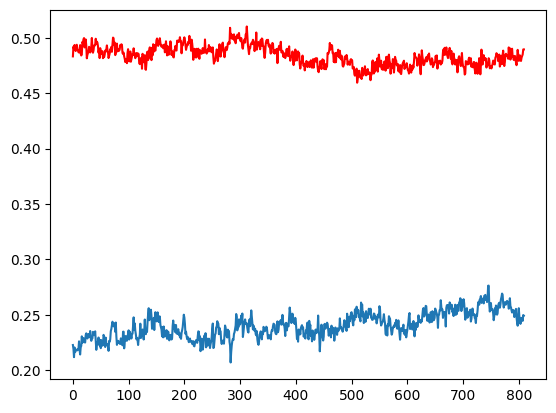

In [144]:
plt.plot(y_e[0]/1000, c='r')
plt.plot(values_O1[0]/1000)
plt.show()

# Learn parameters with a linear layer

In [150]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Define the linear regression model
class param_layer(nn.Module):
    def __init__(self):
        super(param_layer, self).__init__()
        self.fc = nn.Linear(3, 3)  # Output size changed to 7*810=5670
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        #x = self.sigmoid(x)
        return x
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(8000, 810)  # Assuming input size of 8000 and output size of 810

    def forward(self, x):
        x = x.view(-1, 8000)  # Reshape the input
        x = self.linear(x)
        return x

# Use the linear regression model
linear_model = LinearRegression()
param_layer_model = param_layer()
model = ALNModel()

# Define the loss function and optimizers
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=0.001)
optimizer2 = optim.Adam(param_layer_model.parameters(), lr=0.001)

params = torch.randn(1, 3)

total_loss = 0
for i in range(0, 20):
    model.params['duration'] = 400
    param_layer_output = param_layer_model(params)
    params = param_layer_output
    print(params)
    rates_exc = []
    rates_inh = []
    for i in range(0, 88):
        model.params["ext_exc_current"] = square_signals[i]
        params_float = [float(param) for param in param_layer_output[0]]
        # Update ALN model parameters
        model.params["mue_ext_mean"], model.params["mui_ext_mean"], model.params["sigma_ou"] = params_float

        model.run()
        rates_exc.append(model['rates_exc'][0])
        rates_inh.append(model['rates_inh'][0])

    rates_exc_tensor = torch.tensor(rates_exc).float().unsqueeze(1)
    rates_inh_tensor = torch.tensor(rates_inh).float().unsqueeze(1)
    input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
    values_mV = np.array(values_O1[0:88]) / 1000
    real_eeg_data = torch.tensor(values_mV).float().unsqueeze(1)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(input_data_tensor, real_eeg_data, test_size=0.2, random_state=42)

    # Training loop
    num_epochs = 5
    batch_size = 16
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        linear_model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            optimizer2.zero_grad()
            outputs = linear_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer2.step()

        # Calculate validation loss
        linear_model.eval()
        with torch.no_grad():
            test_loss = 0
            for inputs, targets in test_loader:
                outputs = linear_model(inputs)
                test_loss += criterion(outputs, targets).item()
            test_loss /= len(test_loader)

        print(f"Epoch {epoch+1}, Test Loss: {test_loss}")

tensor([[0.3637, 0.3378, 0.5951]], grad_fn=<SigmoidBackward0>)


/Users/aliag/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1, 810])) that is different to the input size (torch.Size([16, 810])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/aliag/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6, 1, 810])) that is different to the input size (torch.Size([6, 810])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/aliag/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1, 810])) that is different to the input size (torch.Size([2, 810])). This will likely lead to incorrect results due to broadcas

Epoch 1, Test Loss: 547.0751647949219
Epoch 2, Test Loss: 444.6168518066406
Epoch 3, Test Loss: 286.68446350097656
Epoch 4, Test Loss: 254.1785430908203
Epoch 5, Test Loss: 220.19320678710938
tensor([[0.3272, 0.4457, 0.6009]], grad_fn=<SigmoidBackward0>)
Epoch 1, Test Loss: 191.4924774169922
Epoch 2, Test Loss: 214.84246826171875
Epoch 3, Test Loss: 188.4012451171875
Epoch 4, Test Loss: 140.8284454345703
Epoch 5, Test Loss: 153.0152359008789
tensor([[0.3237, 0.4409, 0.5967]], grad_fn=<SigmoidBackward0>)
Epoch 1, Test Loss: 115.02166748046875
Epoch 2, Test Loss: 124.744873046875
Epoch 3, Test Loss: 121.79727554321289
Epoch 4, Test Loss: 105.66768264770508
Epoch 5, Test Loss: 117.25041580200195
tensor([[0.3246, 0.4404, 0.5970]], grad_fn=<SigmoidBackward0>)
Epoch 1, Test Loss: 149.9058609008789
Epoch 2, Test Loss: 111.98014831542969
Epoch 3, Test Loss: 117.94803237915039
Epoch 4, Test Loss: 98.00370407104492
Epoch 5, Test Loss: 88.51857376098633
tensor([[0.3245, 0.4405, 0.5970]], grad_fn=

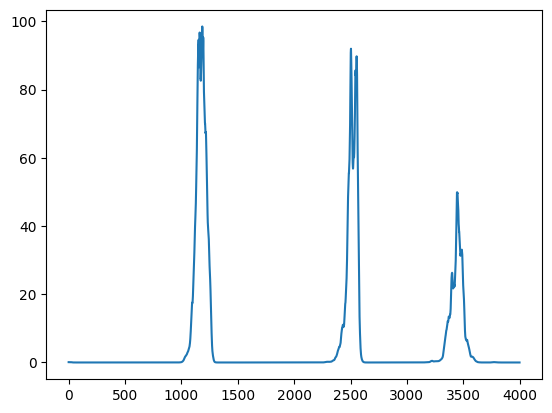

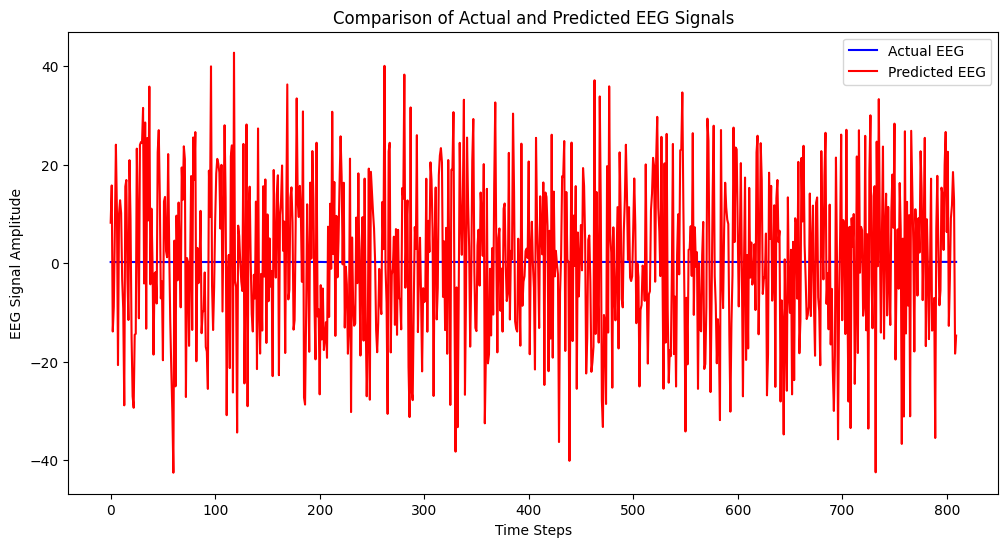

In [151]:
model.params["ext_exc_current"] = square_signals[0]
model.params['duration']=400
model.params["mue_ext_mean"], model.params["mui_ext_mean"], model.params["sigma_ou"]=[0.3245, 0.4405, 0.5970]
model.run()
plt.plot(model['rates_exc'][0])
plt.show()
rates_exc_tensor = torch.tensor(model['rates_exc'][0]).float().unsqueeze(1)  # Add channel dimension
rates_inh_tensor = torch.tensor(model['rates_inh'][0]).float().unsqueeze(1)  # Add channel dimension
input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
# Make prediction
linear_model.eval()
with torch.no_grad():
    prediction = linear_model(input_data_tensor)

# Convert prediction tensor to numpy array
prediction_array = prediction.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(np.array(values_O1[0])/1000, label='Actual EEG', color='blue')
plt.plot(prediction_array, label='Predicted EEG', color='red')
#lt.plot(model['rates_exc'][0])
plt.title('Comparison of Actual and Predicted EEG Signals')
plt.xlabel('Time Steps')
plt.ylabel('EEG Signal Amplitude')
plt.legend()
plt.show()